# Real-time optimization with Modifier Adapation using Gaussian Processes

In [ ]:
# Optional: run this to execute the MA GP routine (takes ~15min)
# The results will be stored in a local sqlite3 DB
!python "../main_magp.py" 

In [ ]:
# First, let's import some necessary stuff
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.style.use('ggplot')

# add the parent folder to path
lib_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(lib_path)

from bussineslogic.rto_data import RTODataModel
md = RTODataModel('/mnt/d/rto_data/rto_test.db')

In [10]:
# Now, let's load the results data
# First, find the last RTO execution ID
last_rto_id = md.get_last_rto_id()

# Then load the results
all_results = pd.DataFrame(md.get_rto_results(last_rto_id,'ma-gp'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id','iteration', 'var_name', 'value'])

In [50]:
# After that, preprocess the DB data
def aggfunc(x):
    return x
all_results_pv = pd.pivot_table(all_results, values='value', index=['run.id','iteration'], columns=['var_name'], aggfunc=aggfunc)
all_results_pv.reset_index(level=all_results_pv.index.names, inplace=True)

# Extract some variables
all_results_pv['g_0'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[0])) 
all_results_pv['g_1'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[1])) 
all_results_pv['g_0_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[0])) 
all_results_pv['g_1_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[1])) 
all_results_pv['g_0_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[0])) 
all_results_pv['g_1_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[1])) 

all_results_pv['tm'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[0])) 
all_results_pv['Fs'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[1])) 
all_results_pv['ts'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[2])) 

In [37]:
# See the available vars
all_results_pv.columns

Index(['run.id', 'iteration', 'cost_model', 'cost_real', 'fobj_modifier',
       'g_model', 'g_modifiers', 'g_real', 'u', 'g_0', 'g_1', 'tm', 'Fs',
       'ts'],
      dtype='object', name='var_name')

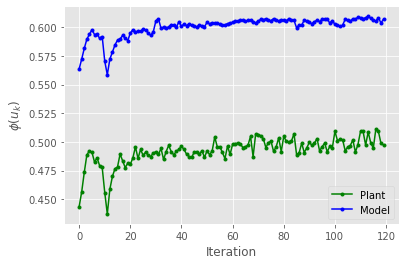

In [33]:
# Plot the convergence results for objective function
plt.plot(all_results_pv['iteration'], -all_results_pv['cost_real'], 'g.-')
plt.plot(all_results_pv['iteration'], -all_results_pv['cost_model'], 'b.-')
plt.legend(['Plant', 'Model'])
plt.xlabel('Iteration')
plt.ylabel('$\phi(u_k)$')
plt.show()


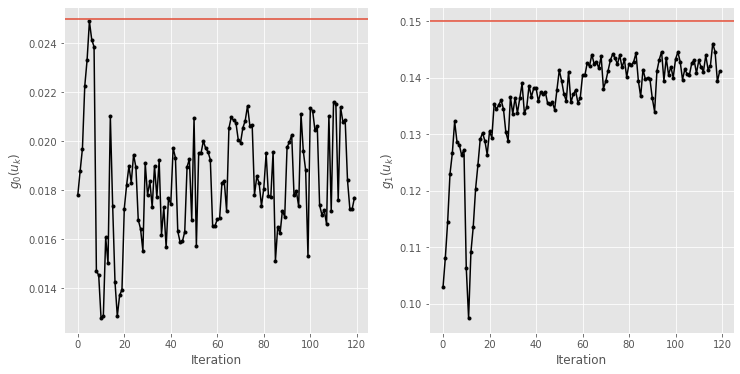

In [35]:
# Plot the convergence results for constraints
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True)
ax[0].plot(all_results_pv['iteration'], all_results_pv['g_0'], 'k.-')
ax[0].axhline(0.025)
ax[1].plot(all_results_pv['iteration'], all_results_pv['g_1'], 'k.-')
ax[1].axhline(0.15)
ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')
ax[0].set_ylabel('$g_0(u_k)$')
ax[1].set_ylabel('$g_1(u_k)$')
fig.show()

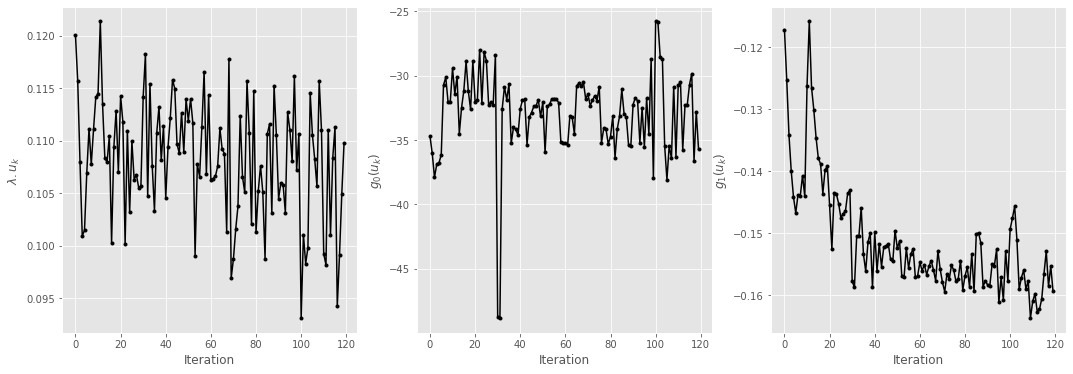

In [55]:
# Plot the cost modifier estimation
fig, ax = plt.subplots(1,3, figsize=(18,6), sharex=True)
ax[0].plot(all_results_pv['iteration'], all_results_pv['fobj_modifier'], 'k.-')
ax[1].plot(all_results_pv['iteration'], all_results_pv['g_0_modifiers'] * 1000, 'k.-')
ax[2].plot(all_results_pv['iteration'], all_results_pv['g_1_modifiers'], 'k.-')
ax[0].set_ylabel('$\lambda . u_k$')
ax[1].set_ylabel('$g_0(u_k)$')
ax[2].set_ylabel('$g_1(u_k)$')
ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')
ax[2].set_xlabel('Iteration')
plt.show()

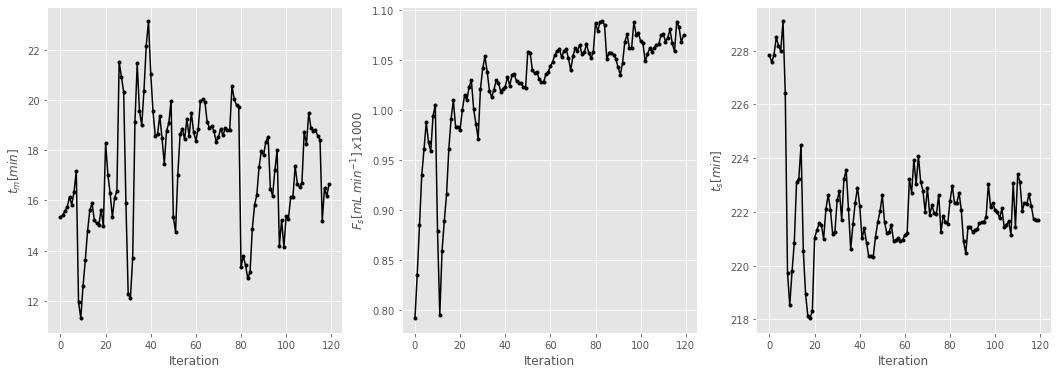

In [56]:
# Plot the convergence results for the input signal
fig, ax = plt.subplots(1,3, figsize=(18,6), sharex=True)
ax[0].plot(all_results_pv['iteration'], all_results_pv['tm'], 'k.-')
ax[1].plot(all_results_pv['iteration'], all_results_pv['Fs'] * 1000, 'k.-')
ax[2].plot(all_results_pv['iteration'], all_results_pv['ts'], 'k.-')

ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')
ax[2].set_xlabel('Iteration')
ax[0].set_ylabel('$t_m [min]$')
ax[1].set_ylabel('$F_s [mL \: min^{-1}] \:x1000$')
ax[2].set_ylabel('$t_s [min]$')
fig.show()